# Machine Learning 

### Importing libraries

In [2]:
import numpy as np
import uproot
import vector
import awkward
import boost_histogram as bh
import matplotlib.pyplot as plt
import mplhep as hep
import sklearn as skl
import torch 
seed_value = 420 
from numpy.random import seed
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
import itertools

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions

### Plotting

In [3]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(awkward.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

### Combinations

In [4]:
def n_combinations(particles, n):
    valid_jets = particles[awkward.num(particles) >= n]
    indices = np.array(list(itertools.combinations(range(awkward.max(awkward.num(valid_jets))), n)))
    combinations = valid_jets[:, indices]
    return combinations

## Extracting Data

### Partonic

In [5]:
tree4 = uproot.open(directory + '4tops_partonic_skimmed_2409.root')['tree']
events4 = tree4.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

tops_pt_4t = awkward.concatenate((events4['top_pt'], events4['anti_top_pt']), axis=1)
tops_e_4t = awkward.concatenate((events4['top_e'], events4['anti_top_e']), axis=1)
tops_eta_4t = awkward.concatenate((events4['top_eta'], events4['anti_top_eta']), axis=1)
tops_phi_4t = awkward.concatenate((events4['top_phi'], events4['anti_top_phi']), axis=1)

tree3W = uproot.open(directory + '3tops_tttW_partonic_skimmed_2609.root')['tree']
events3W = tree3W.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

tops_pt_3W = awkward.concatenate([events3W['top_pt'],events3W['anti_top_pt']], axis=1)
tops_eta_3W = awkward.concatenate([events3W['top_eta'],events3W['anti_top_eta']], axis=1)
tops_phi_3W = awkward.concatenate([events3W['top_phi'],events3W['anti_top_phi']], axis=1)
tops_e_3W = awkward.concatenate([events3W['top_e'],events3W['anti_top_e']], axis=1)

tree3j = uproot.open(directory + '3tops_tttW_partonic_skimmed_2609.root')['tree']
events3j = tree3j.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

tops_pt_3j = awkward.concatenate([events3j['top_pt'],events3j['anti_top_pt']], axis=1)
tops_eta_3j = awkward.concatenate([events3j['top_eta'],events3j['anti_top_eta']], axis=1)
tops_phi_3j = awkward.concatenate([events3j['top_phi'],events3j['anti_top_phi']], axis=1)
tops_e_3j = awkward.concatenate([events3j['top_e'],events3j['anti_top_e']], axis=1)

tops_pt_3 = awkward.concatenate([tops_pt_3W,tops_pt_3j], axis=0)
tops_eta_3 = awkward.concatenate([tops_eta_3W,tops_eta_3j], axis=0)
tops_phi_3 = awkward.concatenate([tops_phi_3W,tops_phi_3j], axis=0)
tops_e_3 = awkward.concatenate([tops_e_3W,tops_e_3j], axis=0)

In [6]:
tree3W = uproot.open(directory + '3tops_tttW_partonic_skimmed_2609.root')['tree']
events3W = tree3W.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

events3W['pt'] = awkward.concatenate([events3W['top_pt'],events3W['anti_top_pt']], axis=1)
events3W['eta'] = awkward.concatenate([events3W['top_eta'],events3W['anti_top_eta']], axis=1)
events3W['phi'] = awkward.concatenate([events3W['top_phi'],events3W['anti_top_phi']], axis=1)
events3W['e'] = awkward.concatenate([events3W['top_e'],events3W['anti_top_e']], axis=1)

mask_tttbarW = (awkward.num(events3W['top_pt']) == 2) & (awkward.num(events3W['anti_top_pt']) == 1)
mask_ttbartbarW = (awkward.num(events3W['top_pt']) == 1) & (awkward.num(events3W['anti_top_pt']) == 2)
tttbarW = events3W[mask_tttbarW]
ttbartbarW = events3W[mask_ttbartbarW]

tree3j = uproot.open(directory + '3tops_tttj_partonic_skimmed_2609.root')['tree']
events3j = tree3j.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

events3j['pt'] = awkward.concatenate([events3j['top_pt'],events3j['anti_top_pt']], axis=1)
events3j['eta'] = awkward.concatenate([events3j['top_eta'],events3j['anti_top_eta']], axis=1)
events3j['phi'] = awkward.concatenate([events3j['top_phi'],events3j['anti_top_phi']], axis=1)
events3j['e'] = awkward.concatenate([events3j['top_e'],events3j['anti_top_e']], axis=1)

In [7]:
pt_mask_1 = events4['top_pt'][:, 0] > 50
pt_mask_2 = events4['top_pt'][:, 1] > 50

eta_mask_1 = (events4['top_eta'][:, 0] > -2.4) & (events4['top_eta'][:, 0] < 2.4)
eta_mask_2 = (events4['top_eta'][:, 1] > -2.4) & (events4['top_eta'][:, 1] < 2.4)

anti_pt_mask_1 = events4['anti_top_pt'][:, 0] > 50
anti_pt_mask_2 = events4['anti_top_pt'][:, 1] > 50

anti_eta_mask_1 = (events4['anti_top_eta'][:, 0] > -2.4) & (events4['anti_top_eta'][:, 0] < 2.4)
anti_eta_mask_2 = (events4['anti_top_eta'][:, 1] > -2.4) & (events4['anti_top_eta'][:, 1] < 2.4)

masks = pt_mask_1 & pt_mask_2 & eta_mask_1 & eta_mask_2 & anti_pt_mask_1 & anti_pt_mask_2 & anti_eta_mask_1 & anti_eta_mask_2

In [8]:
tops = vector.zip({'pt':events4['top_pt'],'eta':events4['top_eta'],'phi':events4['top_phi'], 'mass':172.76})
anti_tops = vector.zip({'pt':events4['anti_top_pt'],'eta':events4['anti_top_eta'],'phi':events4['anti_top_phi'], 'mass':172.76})

filtered_tops= tops[masks]
filtered_anti_tops = anti_tops[masks]

top1 = vector.zip({'pt':events4['top_pt'][:,0],'eta':events4['top_eta'][:,0],'phi':events4['top_phi'][:,0], 'mass':172.76})
top2 = vector.zip({'pt':events4['top_pt'][:,1],'eta':events4['top_eta'][:,1],'phi':events4['top_phi'][:,1], 'mass':172.76})
anti_top1 = vector.zip({'pt':events4['anti_top_pt'][:,0],'eta':events4['anti_top_eta'][:,0],'phi':events4['anti_top_phi'][:,0], 'mass':172.76})
anti_top2 = vector.zip({'pt':events4['anti_top_pt'][:,1],'eta':events4['anti_top_eta'][:,1],'phi':events4['anti_top_phi'][:,1], 'mass':172.76})

all_4tops = awkward.concatenate([awkward.Array([top1]),awkward.Array([top2]),awkward.Array([anti_top1]),awkward.Array([anti_top2])], axis=0)

filtered_top1 = top1[masks]
filtered_top2 = top2[masks]
filtered_anti_top1 = anti_top1[masks]
filtered_anti_top2 = anti_top2[masks]

four_tops = top1+top2+anti_top1+anti_top2
filtered_4_tops = filtered_top1+filtered_top2+filtered_anti_top1+filtered_anti_top2
filtered_4_tops = filtered_4_tops[filtered_4_tops.mass > 1500]

all_filtered_4tops = awkward.concatenate([awkward.Array([filtered_top1]),awkward.Array([filtered_top2]),awkward.Array([filtered_anti_top1]),awkward.Array([filtered_anti_top2])], axis=0)

In [9]:
pt_mask_3tW_1 = events3W['pt'][:,0] > 50
pt_mask_3tW_2 = events3W['pt'][:,1] > 50
pt_mask_3tW_3 = events3W['pt'][:,2] > 50

eta_mask_3tW_1 = (events3W['eta'][:, 0] > -2.4) & (events3W['eta'][:, 0] < 2.4)
eta_mask_3tW_2 = (events3W['eta'][:, 1] > -2.4) & (events3W['eta'][:, 1] < 2.4)
eta_mask_3tW_3 = (events3W['eta'][:, 2] > -2.4) & (events3W['eta'][:, 2] < 2.4)

masks_3tW = pt_mask_3tW_1 & pt_mask_3tW_2 & pt_mask_3tW_3 & eta_mask_3tW_1 & eta_mask_3tW_2 & eta_mask_3tW_3

pt_mask_3tj_1 = events3j['pt'][:,0] > 50
pt_mask_3tj_2 = events3j['pt'][:,1] > 50
pt_mask_3tj_3 = events3j['pt'][:,2] > 50

eta_mask_3tj_1 = (events3j['eta'][:, 0] > -2.4) & (events3j['eta'][:, 0] < 2.4)
eta_mask_3tj_2 = (events3j['eta'][:, 1] > -2.4) & (events3j['eta'][:, 1] < 2.4)
eta_mask_3tj_3 = (events3j['eta'][:, 2] > -2.4) & (events3j['eta'][:, 2] < 2.4)

masks_3tj = pt_mask_3tj_1 & pt_mask_3tj_2 & pt_mask_3tj_3 & eta_mask_3tj_1 & eta_mask_3tj_2 & eta_mask_3tj_3

In [10]:
top1_3tW = vector.zip({'pt':events3W['pt'][:,0],'eta':events3W['eta'][:,0],'phi':events3W['phi'][:,0], 'mass':172.76})
top2_3tW = vector.zip({'pt':events3W['pt'][:,1],'eta':events3W['eta'][:,1],'phi':events3W['phi'][:,1], 'mass':172.76})
top3_3tW = vector.zip({'pt':events3W['pt'][:,2],'eta':events3W['eta'][:,2],'phi':events3W['phi'][:,2], 'mass':172.76})

filtered_top1_3tW = top1_3tW[masks_3tW]
filtered_top2_3tW = top2_3tW[masks_3tW]
filtered_top3_3tW = top3_3tW[masks_3tW]

_3tWs = filtered_top1_3tW + filtered_top2_3tW + filtered_top3_3tW
all_filtered_3tW = awkward.concatenate([awkward.Array([filtered_top1_3tW]),awkward.Array([filtered_top2_3tW]), awkward.Array([filtered_top3_3tW])], axis=0)

top1_3tj = vector.zip({'pt':events3j['pt'][:,0],'eta':events3j['eta'][:,0],'phi':events3j['phi'][:,0], 'mass':172.76})
top2_3tj = vector.zip({'pt':events3j['pt'][:,1],'eta':events3j['eta'][:,1],'phi':events3j['phi'][:,1], 'mass':172.76})
top3_3tj = vector.zip({'pt':events3j['pt'][:,2],'eta':events3j['eta'][:,2],'phi':events3j['phi'][:,2], 'mass':172.76})

filtered_top1_3tj = top1_3tj[masks_3tj]
filtered_top2_3tj = top2_3tj[masks_3tj]
filtered_top3_3tj = top3_3tj[masks_3tj]

_3tjs = filtered_top1_3tj + filtered_top2_3tj + filtered_top3_3tj
all_filtered_3tj = awkward.concatenate([awkward.Array([filtered_top1_3tj]),awkward.Array([filtered_top2_3tj]), awkward.Array([filtered_top3_3tj])], axis=0)

In [11]:
tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'mass':172.76})
tops_3t = vector.zip({'pt':tops_pt_3,'eta':tops_eta_3,'phi':tops_phi_3, 'mass':172.76})

duos_4t = awkward.combinations(tops_4t, 2, axis=1)
duos_3t = awkward.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

### New Ethan Data

In [12]:
tree3j = uproot.open(directory + "3tops_tttj_skimmed_combined.root")
tree3W = uproot.open(directory + "3tops_tttW_skimmed_combined.root")
tree4 = uproot.open(directory + "4tops_inclusive_17july_combined.root")

events_4t_jets = tree4["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.T','Jet.Mass','Jet.Flavor','Jet.BTag','Jet.Charge'])
events_4t_electrons = tree4["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.T','Electron.Charge','Electron.Particle'])
events_4t_electrons['Electron.Mass'] = np.ones_like(events_4t_electrons['Electron.PT']) * 0.511E-3
events_4t_muons = tree4["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi','Muon.T','Muon.Charge','Muon.Particle'])
events_4t_muons['Muon.Mass'] = np.ones_like(events_4t_muons['Muon.PT']) * 0.1057

jets_pt_4t = events_4t_jets['Jet.PT']
jets_eta_4t = events_4t_jets['Jet.Eta']
jets_phi_4t = events_4t_jets['Jet.Phi']
jets_mass_4t = events_4t_jets['Jet.Mass']

leptons_pt_4t = awkward.concatenate((events_4t_electrons['Electron.PT'],events_4t_muons['Muon.PT']), axis=1)
leptons_eta_4t = awkward.concatenate((events_4t_electrons['Electron.Eta'],events_4t_muons['Muon.Eta']), axis=1)
leptons_phi_4t = awkward.concatenate((events_4t_electrons['Electron.Phi'],events_4t_muons['Muon.Phi']), axis=1)
leptons_mass_4t = awkward.concatenate((events_4t_electrons['Electron.Mass'],events_4t_muons['Muon.Mass']), axis=1)

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'mass':jets_mass_4t})
leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'mass':leptons_mass_4t})
all_products_4t = awkward.concatenate((jets_4t,leptons_4t), axis=1)

events_3tj_jets = tree3j["Delphes;1"]["Jet"].arrays(['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.BTag'])
events_3tj_electrons = tree3j["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.Charge','Electron.Particle'])
events_3tj_electrons['Mass'] = np.ones_like(events_3tj_electrons['Electron.PT'])*0.511E-3
events_3tj_muons = tree3j["Delphes;1"]["Muon"].arrays(['Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.Charge', 'Muon.Particle'])
events_3tj_muons['Mass'] = np.ones_like(events_3tj_muons['Muon.PT'])*0.1057

events_3tW_jets = tree3W["Delphes;1"]["Jet"].arrays(['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.BTag'])
events_3tW_electrons = tree3W["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi','Electron.Charge','Electron.Particle'])
events_3tW_electrons['Mass'] = np.ones_like(events_3tW_electrons['Electron.PT'])*0.511E-3
events_3tW_muons = tree3W["Delphes;1"]["Muon"].arrays(['Muon.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.Charge', 'Muon.Particle'])
events_3tW_muons['Mass'] = np.ones_like(events_3tW_muons['Muon.PT'])*105.7

jets_pt_3tj = events_3tj_jets['Jet.PT']
jets_eta_3tj = events_3tj_jets['Jet.Eta']
jets_phi_3tj = events_3tj_jets['Jet.Phi']
jets_mass_3tj = events_3tj_jets['Jet.Mass']

electrons_pt_3tj = events_3tj_electrons['Electron.PT']
electrons_eta_3tj = events_3tj_electrons['Electron.Eta']
electrons_phi_3tj = events_3tj_electrons['Electron.Phi']
electrons_mass_3tj = events_3tj_electrons['Mass']

muons_pt_3tj = events_3tj_muons['Muon.PT']
muons_eta_3tj = events_3tj_muons['Muon.Eta']
muons_phi_3tj = events_3tj_muons['Muon.Phi']
muons_mass_3tj = events_3tj_muons['Mass']

jets_pt_3tW = events_3tW_jets['Jet.PT']
jets_eta_3tW = events_3tW_jets['Jet.Eta']
jets_phi_3tW = events_3tW_jets['Jet.Phi']
jets_mass_3tW = events_3tW_jets['Jet.Mass']

electrons_pt_3tW = events_3tW_electrons['Electron.PT']
electrons_eta_3tW = events_3tW_electrons['Electron.Eta']
electrons_phi_3tW = events_3tW_electrons['Electron.Phi']
electrons_mass_3tW = events_3tW_electrons['Mass']

muons_pt_3tW = events_3tW_muons['Muon.PT']
muons_eta_3tW = events_3tW_muons['Muon.Eta']
muons_phi_3tW = events_3tW_muons['Muon.Phi']
muons_mass_3tW = events_3tW_muons['Mass']

leptons_pt_3tW = awkward.concatenate([electrons_pt_3tW,muons_pt_3tW],axis=1)
leptons_eta_3tW = awkward.concatenate([electrons_eta_3tW,muons_eta_3tW],axis=1)
leptons_phi_3tW = awkward.concatenate([electrons_phi_3tW,muons_phi_3tW],axis=1)
leptons_mass_3tW = awkward.concatenate([electrons_mass_3tW,muons_mass_3tW],axis=1)

leptons_pt_3tj = awkward.concatenate([electrons_pt_3tj,muons_pt_3tj],axis=1)
leptons_eta_3tj = awkward.concatenate([electrons_eta_3tj,muons_eta_3tj],axis=1)
leptons_phi_3tj = awkward.concatenate([electrons_phi_3tj,muons_phi_3tj],axis=1)
leptons_mass_3tj = awkward.concatenate([electrons_mass_3tj,muons_mass_3tj],axis=1)

leptons_pt_3t = awkward.concatenate([leptons_pt_3tW,leptons_pt_3tj])
leptons_eta_3t = awkward.concatenate([leptons_eta_3tW,leptons_eta_3tj])
leptons_phi_3t = awkward.concatenate([leptons_phi_3tW,leptons_phi_3tj])
leptons_mass_3t = awkward.concatenate([leptons_mass_3tW,leptons_mass_3tj])

jets_pt_3t = awkward.concatenate([jets_pt_3tW,jets_pt_3tj])
jets_eta_3t = awkward.concatenate([jets_eta_3tW,jets_eta_3tj])
jets_phi_3t = awkward.concatenate([jets_phi_3tW,jets_phi_3tj])
jets_mass_3t = awkward.concatenate([jets_mass_3tW,jets_mass_3tj])

leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'mass':leptons_mass_3t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'mass':jets_mass_3t})
all_products_3t = awkward.concatenate((jets_3t,leptons_3t), axis=1)

In [13]:
lepton_charges_4t = awkward.concatenate((events_4t_electrons['Electron.Charge'], events_4t_muons['Muon.Charge']), axis=1)
lepton_charges_3tW = awkward.concatenate((events_3tW_electrons['Electron.Charge'], events_3tW_muons['Muon.Charge']), axis=1)
lepton_charges_3tj = awkward.concatenate((events_3tj_electrons['Electron.Charge'], events_3tj_muons['Muon.Charge']), axis=1)
lepton_charges_3t = awkward.concatenate((lepton_charges_3tW, lepton_charges_3tj))

In [14]:
filtered_jets_3t = jets_3t[(awkward.num(leptons_3t)>=2) & (awkward.num(jets_3t)>=3)]
filtered_leptons_3t = leptons_3t[(awkward.num(jets_3t)>=3) & (awkward.num(leptons_3t)>=2)]
filtered_lepton_charges_3t = lepton_charges_3t[(awkward.num(jets_3t)>=3) & (awkward.num(leptons_3t)>=2)]

jets_3t = filtered_jets_3t
leptons_3t = filtered_leptons_3t
lepton_charges_3t = filtered_lepton_charges_3t

filtered_jets_4t = jets_4t[(awkward.num(leptons_4t)>=2) & (awkward.num(jets_4t)>=3)]
filtered_leptons_4t = leptons_4t[(awkward.num(jets_4t)>=3) & (awkward.num(leptons_4t)>=2)]
filtered_lepton_charges_4t = lepton_charges_4t[(awkward.num(jets_4t)>=3) & (awkward.num(leptons_4t)>=2)]

jets_4t = filtered_jets_4t
leptons_4t = filtered_leptons_4t
lepton_charges_4t = filtered_lepton_charges_4t

## Sorting

In [15]:
highest_pt_jet_4t = vector.zip({'pt':jets_4t.rho[:,0],'eta':jets_4t.eta[:,0],'phi':jets_4t.phi[:,0], 'mass':jets_4t.m[:,0]})
highest_pt_jet_3t = vector.zip({'pt':jets_3t.rho[:,0],'eta':jets_3t.eta[:,0],'phi':jets_3t.phi[:,0], 'mass':jets_3t.m[:,0]})

second_highest_pt_jet_4t = vector.zip({'pt':jets_4t.rho[:,1],'eta':jets_4t.eta[:,1],'phi':jets_4t.phi[:,1], 'mass':jets_4t.m[:,1]})
second_highest_pt_jet_3t = vector.zip({'pt':jets_3t.rho[:,1],'eta':jets_3t.eta[:,1],'phi':jets_3t.phi[:,1], 'mass':jets_3t.m[:,1]})

third_highest_pt_jet_4t = vector.zip({'pt':jets_4t.rho[:,2],'eta':jets_4t.eta[:,2],'phi':jets_4t.phi[:,2], 'mass':jets_4t.m[:,2]})
third_highest_pt_jet_3t = vector.zip({'pt':jets_3t.rho[:,2],'eta':jets_3t.eta[:,2],'phi':jets_3t.phi[:,2], 'mass':jets_3t.m[:,2]})

leading_jets_3t = awkward.concatenate(([highest_pt_jet_3t],[second_highest_pt_jet_3t], [third_highest_pt_jet_3t]), axis=0)
leading_jets_4t = awkward.concatenate(([highest_pt_jet_4t],[second_highest_pt_jet_4t], [third_highest_pt_jet_4t]), axis=0)

leading_jets_3t_total = highest_pt_jet_3t+second_highest_pt_jet_3t+third_highest_pt_jet_3t
leading_jets_4t_total = highest_pt_jet_4t+second_highest_pt_jet_4t+third_highest_pt_jet_4t

In [16]:
def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[awkward.num(particles)>=i])!=0:
        particles_i = particles[awkward.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None
    

jet_duos_3t = {}
jet_duos_4t = {}
jet_trios_3t = {}
jet_trios_4t = {}
jet_quads_3t = {}
jet_quads_4t = {}
jet_5_3t = {}
jet_5_4t = {}
jet_6_3t = {}
jet_6_4t = {}
n_combinations(jets_3t, 2, jet_duos_3t, 'jets')
n_combinations(jets_4t, 2, jet_duos_4t, 'jets')
n_combinations(jets_3t, 3, jet_trios_3t, 'jets')
n_combinations(jets_4t, 3, jet_trios_4t, 'jets')
n_combinations(jets_3t, 4, jet_quads_3t, 'jets')
n_combinations(jets_4t, 4, jet_quads_4t, 'jets')
n_combinations(jets_3t, 5, jet_5_3t, 'jets')
n_combinations(jets_4t, 5, jet_5_4t, 'jets')
n_combinations(jets_3t, 6, jet_6_3t, 'jets')
n_combinations(jets_4t, 6, jet_6_4t, 'jets')

lepton_duos_3t = {}
lepton_duos_4t = {}
lepton_trios_3t = {}
lepton_trios_4t = {}
lepton_quads_3t = {}
lepton_quads_4t = {}
n_combinations(leptons_3t, 2, lepton_duos_3t, 'leptons')
n_combinations(leptons_4t, 2, lepton_duos_4t, 'leptons')
n_combinations(leptons_3t, 3, lepton_trios_3t, 'leptons')
n_combinations(leptons_4t, 3, lepton_trios_4t, 'leptons')
n_combinations(leptons_3t, 4, lepton_quads_3t, 'leptons')
n_combinations(leptons_4t, 4, lepton_quads_4t, 'leptons')

In [17]:
jet_duo_masses_3t = np.array([])
jet_deltaphi_3t = np.array([])
jet_deltaR_3t = np.array([])
jet_deltapt_3t = np.array([])
jet_deltaeta_3t = np.array([])
jet_trio_masses_3t = np.array([])
jet_quad_masses_3t = np.array([])
jet_5_masses_3t = np.array([])
jet_6_masses_3t = np.array([])
for key in jet_duos_3t:
    jet_duo_masses_3t = np.concatenate((jet_duo_masses_3t,np.mean((jet_duos_3t[key][:,:,0]+jet_duos_3t[key][:,:,1]).m, axis=1)))
    jet_deltaphi_3t = np.concatenate((jet_deltaphi_3t,np.mean(jet_duos_3t[key][:,:,0].deltaphi(jet_duos_3t[key][:,:,1]), axis=1)))
    jet_deltaR_3t = np.concatenate((jet_deltaR_3t,np.mean(jet_duos_3t[key][:,:,0].deltaR(jet_duos_3t[key][:,:,1]), axis=1)))
    jet_deltaeta_3t = np.concatenate((jet_deltaeta_3t,np.mean(np.abs(jet_duos_3t[key][:,:,0].deltaeta(jet_duos_3t[key][:,:,1])), axis=1)))
    jet_deltapt_3t = np.concatenate((jet_deltapt_3t,np.mean((jet_duos_3t[key][:,:,0].pt - (jet_duos_3t[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_3t = np.concatenate((jet_trio_masses_3t,np.mean((jet_trios_3t[key][:,:,0]+jet_trios_3t[key][:,:,1]+jet_trios_3t[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_3t = np.concatenate((jet_quad_masses_3t,np.mean((jet_quads_3t[key][:,:,0]+jet_quads_3t[key][:,:,1]+jet_quads_3t[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_3t = np.concatenate((jet_5_masses_3t,np.mean((jet_5_3t[key][:,:,0]+jet_5_3t[key][:,:,1]+jet_5_3t[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_3t = np.concatenate((jet_6_masses_3t,np.mean((jet_6_3t[key][:,:,0]+jet_6_3t[key][:,:,1]+jet_6_3t[key][:,:,2]).m, axis=1)))

jet_duo_masses_4t = np.array([])
jet_deltaphi_4t = np.array([])
jet_deltaR_4t = np.array([])
jet_deltapt_4t = np.array([])
jet_deltaeta_4t = np.array([])
jet_trio_masses_4t = np.array([])
jet_quad_masses_4t = np.array([])
jet_5_masses_4t = np.array([])
jet_6_masses_4t = np.array([])
for key in jet_duos_4t:
    jet_duo_masses_4t = np.concatenate((jet_duo_masses_4t,np.mean((jet_duos_4t[key][:,:,0]+jet_duos_4t[key][:,:,1]).m, axis=1)))
    jet_deltaphi_4t = np.concatenate((jet_deltaphi_4t,np.mean(jet_duos_4t[key][:,:,0].deltaphi(jet_duos_4t[key][:,:,1]), axis=1)))
    jet_deltaR_4t = np.concatenate((jet_deltaR_4t,np.mean(jet_duos_4t[key][:,:,0].deltaR(jet_duos_4t[key][:,:,1]), axis=1)))
    jet_deltaeta_4t = np.concatenate((jet_deltaeta_4t,np.mean(np.abs(jet_duos_4t[key][:,:,0].deltaeta(jet_duos_4t[key][:,:,1])), axis=1)))
    jet_deltapt_4t = np.concatenate((jet_deltapt_4t,np.mean((jet_duos_4t[key][:,:,0].pt - (jet_duos_4t[key][:,:,1]).pt), axis=1)))
    if key != 'jets_2':
        jet_trio_masses_4t = np.concatenate((jet_trio_masses_4t,np.mean((jet_trios_4t[key][:,:,0]+jet_trios_4t[key][:,:,1]+jet_trios_4t[key][:,:,2]).m, axis=1)))
        if key != 'jets_3':
            jet_quad_masses_4t = np.concatenate((jet_quad_masses_4t,np.mean((jet_quads_4t[key][:,:,0]+jet_quads_4t[key][:,:,1]+jet_quads_4t[key][:,:,2]).m, axis=1)))
            if key != 'jets_4':
                jet_5_masses_4t = np.concatenate((jet_5_masses_4t,np.mean((jet_5_4t[key][:,:,0]+jet_5_4t[key][:,:,1]+jet_5_4t[key][:,:,2]).m, axis=1)))
                if key != 'jets_5':
                    jet_6_masses_4t = np.concatenate((jet_6_masses_4t,np.mean((jet_6_4t[key][:,:,0]+jet_6_4t[key][:,:,1]+jet_6_4t[key][:,:,2]).m, axis=1)))

lepton_duo_masses_3t = np.array([])
lepton_deltaphi_3t = np.array([])
lepton_deltaR_3t = np.array([])
lepton_deltapt_3t = np.array([])
lepton_deltaeta_3t = np.array([])
lepton_trio_masses_3t = np.array([])
lepton_quad_masses_3t = np.array([])
for key in lepton_duos_3t:
    lepton_duo_masses_3t = np.concatenate((lepton_duo_masses_3t,np.mean((lepton_duos_3t[key][:,:,0]+lepton_duos_3t[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_3t = np.concatenate((lepton_deltaphi_3t,np.mean(lepton_duos_3t[key][:,:,0].deltaphi(lepton_duos_3t[key][:,:,1]), axis=1)))
    lepton_deltaR_3t = np.concatenate((lepton_deltaR_3t,np.mean(lepton_duos_3t[key][:,:,0].deltaR(lepton_duos_3t[key][:,:,1]), axis=1)))
    lepton_deltaeta_3t = np.concatenate((lepton_deltaeta_3t,np.mean(np.abs(lepton_duos_3t[key][:,:,0].deltaeta(lepton_duos_3t[key][:,:,1])), axis=1)))
    lepton_deltapt_3t = np.concatenate((lepton_deltapt_3t,np.mean((lepton_duos_3t[key][:,:,0].pt - (lepton_duos_3t[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_3t = np.concatenate((lepton_trio_masses_3t,np.mean((lepton_trios_3t[key][:,:,0]+lepton_trios_3t[key][:,:,1]+lepton_trios_3t[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_3t = np.concatenate((lepton_quad_masses_3t,np.mean((lepton_quads_3t[key][:,:,0]+lepton_quads_3t[key][:,:,1]+lepton_quads_3t[key][:,:,2]+lepton_quads_3t[key][:,:,3]).m, axis=1)))

lepton_duo_masses_4t = np.array([])
lepton_deltaphi_4t = np.array([])
lepton_deltaeta_4t = np.array([])
lepton_deltaR_4t = np.array([])
lepton_deltapt_4t = np.array([])
lepton_trio_masses_4t = np.array([])
lepton_quad_masses_4t = np.array([])
for key in lepton_duos_4t:
    lepton_duo_masses_4t = np.concatenate((lepton_duo_masses_4t,np.mean((lepton_duos_4t[key][:,:,0]+lepton_duos_4t[key][:,:,1]).m, axis=1)))
    lepton_deltaphi_4t = np.concatenate((lepton_deltaphi_4t,np.mean(lepton_duos_4t[key][:,:,0].deltaphi(lepton_duos_4t[key][:,:,1]), axis=1)))
    lepton_deltaR_4t = np.concatenate((lepton_deltaR_4t,np.mean(lepton_duos_4t[key][:,:,0].deltaR(lepton_duos_4t[key][:,:,1]), axis=1)))
    lepton_deltaeta_4t = np.concatenate((lepton_deltaeta_4t,np.mean(np.abs(lepton_duos_4t[key][:,:,0].deltaeta(lepton_duos_4t[key][:,:,1])), axis=1)))
    lepton_deltapt_4t = np.concatenate((lepton_deltapt_4t,np.mean((lepton_duos_4t[key][:,:,0].pt - (lepton_duos_4t[key][:,:,1]).pt), axis=1)))
    if key != 'leptons_2':
        lepton_trio_masses_4t = np.concatenate((lepton_trio_masses_4t,np.mean((lepton_trios_4t[key][:,:,0]+lepton_trios_4t[key][:,:,1]+lepton_trios_4t[key][:,:,2]).m, axis=1)))
        if key != 'leptons_3':
            lepton_quad_masses_4t = np.concatenate((lepton_quad_masses_4t,np.mean((lepton_quads_4t[key][:,:,0]+lepton_quads_4t[key][:,:,1]+lepton_quads_4t[key][:,:,2]+lepton_quads_4t[key][:,:,3]).m, axis=1)))


## Machine learning

### Defining function

In [18]:
def neural_network(signal_data, background_data):

    epochs = 10  # number of training epochs
    batch_size = 32  # number of samples per batch
    input_size = len(signal_data)  # The number of features
    num_classes = 2  # The number of output classes. In this case: [signal, background]
    hidden1_size = 20  # The number of nodes at the first hidden layer
    hidden2_size = 20  # The number of nodes at the second hidden layer
    learning_rate = 0.01  # The speed of convergence
    verbose = True  # flag for printing out stats at each epoch
    torch.manual_seed(seed_value)  # set random seed for PyTorch

    signal_combined = np.column_stack(signal_data)
    background_combined = np.column_stack(background_data)

    data_combined = np.concatenate([signal_combined,background_combined])
    print(data_combined)

    signal_labels = np.ones(len(signal_data[0]), dtype=int)  # Shape (14009,)
    background_labels = np.zeros(len(background_data[0]), dtype=int)  # Shape (371486,)
    #print(signal_labels)
    #print(background_labels)
    # Combine labels
    labels_combined = awkward.concatenate([signal_labels, background_labels])
    print(labels_combined)
    print(np.shape(data_combined))
    print(len(labels_combined))

    X_train, X_test, y_train, y_test = train_test_split(data_combined, labels_combined, test_size=0.33, random_state=seed_value)
    #print(y_test)
    #print(X_train)
    scaler = StandardScaler()
    scaler.fit(X_train)
    from sklearn.utils import class_weight

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #print(X_train_scaled)
    class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
    RF_clf = RandomForestClassifier(criterion="gini", max_depth=8, n_estimators=30, random_state=seed_value, class_weight={0: class_weights[0], 1: class_weights[1]})  # initialise your random forest classifier
    RF_clf.fit(X_train_scaled, y_train)  # fit to the training data
    y_pred_RF = RF_clf.predict(X_test_scaled)  # make predictions on the test data
    print(y_pred_RF[:15])
    # See how well the classifier does
    print("Accuracy score of random forest :", accuracy_score(y_test, y_pred_RF))

    importances = RF_clf.feature_importances_
    plt.bar(range(len(importances)), importances)
    plt.show()
    X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
    y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

    X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors

    X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
    X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

    train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
    valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

    train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
    valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

    class Classifier_MLP(nn.Module):  # define Multi-Layer Perceptron
        def __init__(self, in_dim, hidden_dim1, hidden_dim2, out_dim):  # initialise
            super().__init__()  # lets you avoid referring to the base class explicitly

            self.h1 = nn.Linear(in_dim, hidden_dim1)  # hidden layer 1
            self.h2 = nn.Linear(hidden_dim1,hidden_dim2)  # hidden layer 2
            self.out = nn.Linear(hidden_dim2, out_dim)  # output layer
            self.out_dim = out_dim  # output layer dimension

        def forward(self, x):  # order of the layers

            x = F.relu(self.h1(x))  # ReLU activation for first hidden layer
            x = F.relu(self.h2(x))  # ReLU activation for second hidden layer
            x = self.out(x)  # no activation function for output layer

            return x, F.softmax(x, dim=1)  # SoftMax function
        
    NN_clf = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden1_size, hidden_dim2=hidden2_size, out_dim=num_classes)
    optimizer = torch.optim.SGD(NN_clf.parameters(), lr=learning_rate)

    _results = []  # define empty list for epoch, train_loss, valid_loss, accuracy
    for epoch in range(epochs):  # loop over the dataset multiple times

        # training loop for this epoch
        NN_clf.train()  # set the model into training mode

        train_loss = 0.0  # start training loss counter at 0
        for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):  # loop over train_loader

            NN_clf.zero_grad()  # set the gradients to zero before backpropragation because PyTorch accumulates the gradients
            out, prob = NN_clf(x_train_batch)  # get output and probability on this training batch
            # Calculate loss
            loss = F.cross_entropy(out, y_train_batch)  # This should work correctly

            loss.backward()  # compute dloss/dx
            optimizer.step()  # updates the parameters

            train_loss += loss.item() * x_train_batch.size(0)  # add to counter for training loss

        train_loss /= len(train_loader.dataset)  # divide train loss by length of train_loader

        if verbose:  # if verbose flag set to True
            print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))

    # validation loop for this epoch:
        NN_clf.eval()  # set the model into evaluation mode
        with torch.no_grad():  # turn off the gradient calculations

            correct = 0
            valid_loss = 0  # start counters for number of correct and validation loss
            for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):  # loop over validation loader

                out, prob = NN_clf(x_valid_batch)  # get output and probability on this validation batch
                loss = F.cross_entropy(out, y_valid_batch)  # compute loss as cross entropy

                valid_loss += loss.item() * x_valid_batch.size(0)  # add to counter for validation loss

                preds = prob.argmax(dim=1, keepdim=True)  # get predictions
                correct += (preds.eq(y_valid_batch.view_as(preds)).sum().item())  # count number of correct

            valid_loss /= len(valid_loader.dataset)  # divide validation loss by length of validation dataset
            accuracy = correct / len(valid_loader.dataset)  # calculate accuracy as number of correct divided by total

        if verbose:  # if verbose flag set to True
            print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

    # create output row:
        _results.append([epoch, train_loss, valid_loss, accuracy])

    results = np.array(_results)  # make array of results
    print("Finished Training")
    print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
    y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

    X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)

    out, prob = NN_clf(X_test_var)
    y_pred_NN = (prob.cpu().detach().numpy().argmax(axis=1))

    print("Accuracy score of neural network: ", accuracy_score(y_test, y_pred_NN))

    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_test, RF_clf.predict_proba(X_test)[:,1])
    print(f'AUC: {auc}')

    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(RF_clf, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f'Cross-Validation AUC: {scores.mean()}')

    decisions_rf = RF_clf.predict_proba(X_test_scaled)[:, 1]
    decisions_nn = (NN_clf(X_test_var)[1][:, 1].cpu().detach().numpy())

    from sklearn.metrics import confusion_matrix
    y_pred = RF_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print(decisions_rf)
    print(decisions_rf)

    print(classification_report(y_test, y_pred_RF, target_names=["background", "signal"]))
    print(classification_report(y_test, y_pred_NN, target_names=["background", "signal"]))
    
    fig, ax = plt.subplots(1,4, figsize=(20,8))
    histogram([decisions_rf[y_test == 0], decisions_rf[y_test == 1]], 50, ['Background Events','Signal Events'], ax[0], ratio=False, density=False)
    ax[0].set_xlabel("Threshold")  # x-axis label
    ax[0].semilogy()  # make the y-axis semi-log

    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, decisions_rf)
    fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, decisions_nn)

    
    ax[1].plot(fpr_rf, tpr_rf, label="Random Forest")  # plot random forest ROC
    ax[1].plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
    ax[1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
    ax[1].set_xlabel("False Positive Rate")  # x-axis label
    ax[1].set_ylabel("True Positive Rate")  # y-axis label
    ax[1].grid()  # add a grid to the plot
    ax[1].legend()

    def AMS(TPR,FPR,b_r):
        AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
        return AMS

    b_reg = 0.001
    ams_rf = AMS(tpr_rf,fpr_rf,b_reg)
    ams_nn = AMS(tpr_nn,fpr_nn,b_reg)
    
    ax[2].plot(thresholds_rf, ams_rf, label="Random Forest")  # plot random forest AMS
    ax[2].plot(thresholds_nn, ams_nn, linestyle="dashed", label="Neural Network")  # plot neural network AMS
    ax[2].set_xlabel("Threshold")  # x-axis label
    ax[2].set_ylabel("AMS")  # y-axis label
    ax[2].set_title(f"AMS with $b_r$ = {b_reg:.2g}")  # add plot title
    ax[2].legend()

    def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
        decisions = [] # list to hold decisions of classifier
        for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
            if hasattr(clf, "predict_proba"): # if predict_proba function exists
                d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
                d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
            else: # predict_proba function doesn't exist
                X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
                y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
                X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
                d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
                d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
            decisions += [d1, d2] # add to list of classifier decision
    
        highest_decision = max(np.max(d) for d in decisions) # get maximum score
        bin_edges = [] # list to hold bin edges
        bin_edge = -0.1 # start counter for bin_edges
        while bin_edge < highest_decision: # up to highest score
            bin_edge += 0.1 # increment
            bin_edges.append(bin_edge)

        histogram([decisions[0],decisions[1]], bin_edges, ['Background (training data)','Signal (training data)'],ax[3],ratio=False, density = True)

        hist_background, bin_edges = np.histogram(decisions[2], bins=bin_edges, density=True )
    
        scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
        err_background = np.sqrt(hist_background * scale) / scale # error on test background

        width = 0.1 # histogram bin width
        center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
        ax[3].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o',  c='blue', label='Background (test)' ) # Background (test)
    
        hist_signal, bin_edges = np.histogram(decisions[3],bins=bin_edges,density=True )
        scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
        err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
        ax[3].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', c='orange', label='Signal (test)' )
    
        ax[3].set_xlabel(xlabel) # write x-axis label
        ax[3].set_ylabel("Arbitrary units") # write y-axis label
        ax[3].legend() # add legend
    compare_train_test(RF_clf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest output")
    return None

### Data conversions

In [19]:
jets_4t_pt_flat = awkward.flatten(jets_4t.pt)
jets_4t_eta_flat = awkward.flatten(jets_4t.eta)
jets_4t_phi_flat = awkward.flatten(jets_4t.phi)
jets_3t_pt_flat = awkward.flatten(jets_3t.pt)
jets_3t_eta_flat = awkward.flatten(jets_3t.eta)
jets_3t_phi_flat = awkward.flatten(jets_3t.phi)
jets_pt_flat = np.concatenate([jets_4t_pt_flat,jets_3t_pt_flat])
jets_eta_flat = np.concatenate([jets_4t_eta_flat,jets_3t_eta_flat])
jets_phi_flat = np.concatenate([jets_4t_phi_flat,jets_3t_phi_flat])

In [20]:
leptons_4t_pt_flat = awkward.flatten(leptons_4t.pt)
leptons_4t_eta_flat = awkward.flatten(leptons_4t.eta)
leptons_4t_phi_flat = awkward.flatten(leptons_4t.phi)
leptons_3t_pt_flat = awkward.flatten(leptons_3t.pt)
leptons_3t_eta_flat = awkward.flatten(leptons_3t.eta)
leptons_3t_phi_flat = awkward.flatten(leptons_3t.phi)
leptons_pt_flat = np.concatenate([leptons_4t_pt_flat,leptons_3t_pt_flat])
leptons_eta_flat = np.concatenate([leptons_4t_eta_flat,leptons_3t_eta_flat])
leptons_phi_flat = np.concatenate([leptons_4t_phi_flat,leptons_3t_phi_flat])

In [21]:
jets_4t_total_4 = np.sum(jets_4t, axis=1)
jets_4t_H_t = np.sum(jets_4t.pt, axis=1)
jets_pt_balance_4t = jets_4t_total_4.pt/jets_4t_H_t

leptons_4t_total_4 = np.sum(leptons_4t, axis=1)
leptons_4t_H_t = np.sum(leptons_4t.pt, axis=1)
leptons_pt_balance_4t = leptons_4t_total_4.pt/leptons_4t_H_t

jets_3t_total_4 = np.sum(jets_3t, axis=1)
jets_3t_H_t = np.sum(jets_3t.pt, axis=1)
jets_pt_balance_3t = jets_3t_total_4.pt/jets_3t_H_t

leptons_3t_total_4 = np.sum(leptons_3t, axis=1)
leptons_3t_H_t = np.sum(leptons_3t.pt, axis=1)
leptons_pt_balance_3t = leptons_3t_total_4.pt/leptons_3t_H_t

total_4_3t = np.sum(all_products_3t, axis=1)
H_t_3t = np.sum(all_products_3t.pt, axis=1)
pt_balance_3t = total_4_3t.pt/H_t_3t

total_4_4t = np.sum(all_products_4t, axis=1)
H_t_4t = np.sum(all_products_4t.pt, axis=1)
pt_balance_4t = total_4_4t.pt/H_t_4t

In [22]:
leptons_2LSS_4t = leptons_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]
jets_2LSS_4t = jets_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]

leptons_3L_4t = leptons_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]
jets_3L_4t = jets_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]

ratio_2LSS_4t = len(leptons_2LSS_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))
ratio_3L_4t = len(leptons_3L_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))

leptons_2LSS_3t = leptons_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]
jets_2LSS_3t = jets_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]

leptons_3L_3t = leptons_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]
jets_3L_3t = jets_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]

In [23]:
jets_pt_balance_4t_2LSS = np.sum(jets_2LSS_4t, axis=1).pt/np.sum(jets_2LSS_4t.pt, axis=1)
jets_pt_balance_3t_2LSS = np.sum(jets_2LSS_3t, axis=1).pt/np.sum(jets_2LSS_3t.pt, axis=1)

jets_pt_balance_4t_3L = np.sum(jets_3L_4t, axis=1).pt/np.sum(jets_3L_4t.pt, axis=1)
jets_pt_balance_3t_3L = np.sum(jets_3L_3t, axis=1).pt/np.sum(jets_3L_3t.pt, axis=1)

leptons_pt_balance_4t_2LSS = np.sum(leptons_2LSS_4t, axis=1).pt/np.sum(leptons_2LSS_4t.pt, axis=1)
leptons_pt_balance_3t_2LSS = np.sum(leptons_2LSS_3t, axis=1).pt/np.sum(leptons_2LSS_3t.pt, axis=1)

leptons_pt_balance_4t_3L = np.sum(leptons_3L_4t, axis=1).pt/np.sum(leptons_3L_4t.pt, axis=1)
leptons_pt_balance_3t_3L = np.sum(leptons_3L_3t, axis=1).pt/np.sum(leptons_3L_3t.pt, axis=1)

In [151]:
sum_pt_jets_3t = np.sum(jets_3t.pt, axis=1)

S_xy_jets_3t = np.zeros((len(jets_3t),2,2))


S_xy_jets_3t[:,0,0] = np.sum(jets_3t.px**2/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,0,1] = np.sum((jets_3t.px*jets_3t.py)/ jets_3t.pt, axis=1)
S_xy_jets_3t[:,1,0] = S_xy_jets_3t[:,0,1]
S_xy_jets_3t[:,1,1] = np.sum(jets_3t.py**2/ jets_3t.pt, axis=1)


S_xy_jets_3t = S_xy_jets_3t/sum_pt_jets_3t[:,np.newaxis,np.newaxis]

eigenvalues_jets_3t = np.linalg.eigvalsh(S_xy_jets_3t)

sphericity_jets_3t = 2*np.min(eigenvalues_jets_3t, axis=1)/np.sum(eigenvalues_jets_3t, axis=1)

sum_pt_jets_4t = np.sum(jets_4t.pt, axis=1)

S_xy_jets_4t = np.zeros((len(jets_4t),2,2))


S_xy_jets_4t[:,0,0] = np.sum(jets_4t.px**2/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,0,1] = np.sum((jets_4t.px*jets_4t.py)/ jets_4t.pt, axis=1)
S_xy_jets_4t[:,1,0] = S_xy_jets_4t[:,0,1]
S_xy_jets_4t[:,1,1] = np.sum(jets_4t.py**2/ jets_4t.pt, axis=1)


S_xy_jets_4t = S_xy_jets_4t/sum_pt_jets_4t[:,np.newaxis,np.newaxis]

eigenvalues_jets_4t = np.linalg.eigvalsh(S_xy_jets_4t)

sphericity_jets_4t = 2*np.min(eigenvalues_jets_4t, axis=1)/np.sum(eigenvalues_jets_4t, axis=1)

sum_pt_leptons_3t = np.sum(leptons_3t.pt, axis=1)

S_xy_leptons_3t = np.zeros((len(leptons_3t),2,2))

S_xy_leptons_3t[:,0,0] = np.sum(leptons_3t.px**2/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,0,1] = np.sum((leptons_3t.px*leptons_3t.py)/ leptons_3t.pt, axis=1)
S_xy_leptons_3t[:,1,0] = S_xy_leptons_3t[:,0,1]
S_xy_leptons_3t[:,1,1] = np.sum(leptons_3t.py**2/ leptons_3t.pt, axis=1)


S_xy_leptons_3t = S_xy_leptons_3t/sum_pt_leptons_3t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_3t = np.linalg.eigvalsh(S_xy_leptons_3t)

sphericity_leptons_3t = 2*np.min(eigenvalues_leptons_3t, axis=1)/np.sum(eigenvalues_leptons_3t, axis=1)

sum_pt_leptons_4t = np.sum(leptons_4t.pt, axis=1)

S_xy_leptons_4t = np.zeros((len(leptons_4t),2,2))


S_xy_leptons_4t[:,0,0] = np.sum(leptons_4t.px**2/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,0,1] = np.sum((leptons_4t.px*leptons_4t.py)/ leptons_4t.pt, axis=1)
S_xy_leptons_4t[:,1,0] = S_xy_leptons_4t[:,0,1]
S_xy_leptons_4t[:,1,1] = np.sum(leptons_4t.py**2/ leptons_4t.pt, axis=1)


S_xy_leptons_4t = S_xy_leptons_4t/sum_pt_leptons_4t[:,np.newaxis,np.newaxis]

eigenvalues_leptons_4t = np.linalg.eigvalsh(S_xy_leptons_4t)

sphericity_leptons_4t = 2*np.min(eigenvalues_leptons_4t, axis=1)/np.sum(eigenvalues_leptons_4t, axis=1)

sum_pt_all_3t = np.sum(all_products_3t.pt, axis=1)

S_all_3t = np.zeros((len(all_products_3t),2,2))


S_all_3t[:,0,0] = np.sum(all_products_3t.px**2/ all_products_3t.pt, axis=1)
S_all_3t[:,0,1] = np.sum((all_products_3t.px*all_products_3t.py)/ all_products_3t.pt, axis=1)
S_all_3t[:,1,0] = S_all_3t[:,0,1]
S_all_3t[:,1,1] = np.sum(all_products_3t.py**2/ all_products_3t.pt, axis=1)


S_all_3t = S_all_3t/sum_pt_all_3t[:,np.newaxis,np.newaxis]

eigenvalues_all_3t = np.linalg.eigvalsh(S_all_3t)

sphericity_all_3t = 2*np.min(eigenvalues_all_3t, axis=1)/np.sum(eigenvalues_all_3t, axis=1)

sum_pt_all_4t = np.sum(all_products_4t.pt, axis=1)

S_all_4t = np.zeros((len(all_products_4t),2,2))


S_all_4t[:,0,0] = np.sum(all_products_4t.px**2/ all_products_4t.pt, axis=1)
S_all_4t[:,0,1] = np.sum((all_products_4t.px*all_products_4t.py)/ all_products_4t.pt, axis=1)
S_all_4t[:,1,0] = S_all_4t[:,0,1]
S_all_4t[:,1,1] = np.sum(all_products_4t.py**2/ all_products_4t.pt, axis=1)


S_all_4t = S_all_4t/sum_pt_all_4t[:,np.newaxis,np.newaxis]

eigenvalues_all_4t = np.linalg.eigvalsh(S_all_4t)

sphericity_all_4t = 2*np.min(eigenvalues_all_4t, axis=1)/np.sum(eigenvalues_all_4t, axis=1)

In [25]:
sum_pt_3t = np.sum(tops_3t.pt, axis=1)

S_xy_3t = np.zeros((len(tops_3t),2,2))


S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)


S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)

transverse_sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)

S_xy_4t = np.zeros((len(tops_4t),2,2))


S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)


S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)

transverse_sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

In [26]:
sum_p_3t = np.sum(tops_3t.p, axis=1)

S_xyz_3t = np.zeros((len(tops_3t),3,3))


S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)


S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)

sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)

S_xyz_4t = np.zeros((len(tops_4t),3,3))


S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)


S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)

sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

In [27]:
lepton_duo_masses = np.concatenate([lepton_duo_masses_4t,lepton_duo_masses_3t])
lepton_trio_masses = np.concatenate([lepton_trio_masses_4t,lepton_trio_masses_3t])

jet_ht = np.concatenate([jets_4t_H_t,jets_3t_H_t])
total_ht = np.concatenate([H_t_4t,H_t_3t])

jet_sum_pt = np.concatenate([jets_4t_total_4.pt,jets_3t_total_4.pt])
jet_pt_balance_3L = np.concatenate([jets_pt_balance_4t_3L,jets_pt_balance_3t_3L])
all_sum_pt = np.concatenate([total_4_4t.pt,total_4_3t.pt])
all_pt_balance = np.concatenate([pt_balance_4t,pt_balance_3t])
jet_pt_balance_2LSS = np.concatenate([jets_pt_balance_4t_2LSS,jets_pt_balance_3t_2LSS])

total_inv_mass = np.concatenate([total_4_4t.m,total_4_3t.m])
total_jet_inv_mass = np.concatenate([jets_4t_total_4.m,jets_3t_total_4.m])
sum_individual_inv_mass = np.concatenate([np.sum(jets_4t.m,axis=1),np.sum(jets_3t.m,axis=1)])

jet_sphericity = np.concatenate([sphericity_jets_4t,sphericity_jets_3t])
total_sphericity = np.concatenate([sphericity_all_4t,sphericity_all_3t])
partonic_transverse_sphericity = np.concatenate([transverse_sphericity_4t,transverse_sphericity_3t])
partonic_sphericity = np.concatenate([sphericity_4t,sphericity_3t])

In [96]:
print(len(sum_individual_inv_mass))

121838


In [28]:
#convert to 1 for signal and 0 for background
y_4t_pt = np.ones(len(leptons_4t_pt_flat))
y_3t_pt = np.zeros(len(leptons_3t_pt_flat))
y_4t_eta = np.ones(len(leptons_4t_eta_flat))
y_3t_eta = np.zeros(len(leptons_3t_eta_flat))
y_4t_phi = np.ones(len(leptons_4t_phi_flat))
y_3t_phi = np.zeros(len(leptons_3t_phi_flat))

y_4t_duo_masses = np.ones(len(lepton_duo_masses_4t))
y_3t_duo_masses = np.zeros(len(lepton_duo_masses_3t))
y_4t_trio_masses = np.ones(len(lepton_trio_masses_4t))
y_3t_trio_masses = np.zeros(len(lepton_trio_masses_3t))

y_4t_jet_ht = np.ones(len(jets_4t_H_t))
y_3t_jet_ht = np.zeros(len(jets_3t_H_t))
y_4t_ht = np.ones(len(H_t_4t))
y_3t_ht = np.zeros(len(H_t_3t))

y_4t_jet_pt_balance_3L = np.ones(len(leptons_pt_balance_4t_3L))
y_3t_jet_pt_balance_3L = np.zeros(len(leptons_pt_balance_3t_3L))
y_jets_4t_total_4_pt = np.ones(len(jets_4t_total_4.pt))
y_jets_3t_total_4_pt = np.zeros(len(jets_3t_total_4.pt))
y_total_4_4t_pt = np.ones(len(total_4_4t.pt))
y_total_4_3t_pt = np.zeros(len(total_4_3t.pt))
y_4t_all_pt_balance = np.ones(len(pt_balance_4t))
y_3t_all_pt_balance = np.zeros(len(pt_balance_3t))
y_4t_jets_pt_balance_2LSS = np.ones(len(jets_pt_balance_4t_2LSS))
y_3t_jets_pt_balance_2LSS = np.zeros(len(jets_pt_balance_3t_2LSS))

y_4t_total_4_inv_mass = np.ones(len(total_4_4t.m))
y_3t_total_4_inv_mass = np.zeros(len(total_4_3t.m))
y_4t_jet_inv_mass = np.ones(len(jets_4t_total_4.m))
y_3t_jet_inv_mass = np.zeros(len(jets_3t_total_4.m))
y_4t_jet_sum_individual_inv_mass = np.ones(len(np.sum(jets_4t.m,axis=1)))
y_3t_jet_sum_individual_inv_mass = np.zeros(len(np.sum(jets_3t.m,axis=1)))

y_4t_jet_sphericity = np.ones(len(sphericity_jets_4t))
y_3t_jet_sphericity = np.zeros(len(sphericity_jets_3t))
y_4t_all_sphericity = np.ones(len(sphericity_all_4t))
y_3t_all_sphericity = np.zeros(len(sphericity_all_3t))
y_4t_partonic_transverse_sphericity = np.ones(len(sphericity_4t))
y_3t_partonic_transverse_sphericity = np.zeros(len(sphericity_3t))
y_4t_partonic_sphericity = np.ones(len(sphericity_4t))
y_3t_partonic_sphericity = np.zeros(len(sphericity_3t))
#concatenate data

y_pt = np.concatenate([y_4t_pt,y_3t_pt])
y_eta = np.concatenate([y_4t_eta,y_3t_eta])
y_phi = np.concatenate([y_4t_phi,y_3t_phi])

y_duo_masses = np.concatenate([y_4t_duo_masses,y_3t_duo_masses])
y_trio_masses = np.concatenate([y_4t_trio_masses,y_3t_trio_masses])

y_jets_ht = np.concatenate([y_4t_jet_ht,y_3t_jet_ht])
y_ht = np.concatenate([y_4t_ht,y_3t_ht])

y_jet_pt_balance_3L = np.concatenate([y_4t_jet_pt_balance_3L,y_3t_jet_pt_balance_3L])
y_jet_sum_pt = np.concatenate([y_jets_4t_total_4_pt,y_jets_3t_total_4_pt])
y_all_sum_pt = np.concatenate([y_total_4_4t_pt,y_total_4_3t_pt])
y_all_pt_balance = np.concatenate([y_4t_all_pt_balance,y_3t_all_pt_balance])
y_jet_pt_balance_2LSS = np.concatenate([y_4t_jets_pt_balance_2LSS,y_3t_jets_pt_balance_2LSS])

y_total_4_inv_mass = np.concatenate([y_4t_total_4_inv_mass,y_3t_total_4_inv_mass])
y_jet_4_inv_mass = np.concatenate([y_4t_jet_inv_mass,y_3t_jet_inv_mass])
y_sum_individual_inv_mass = np.concatenate([y_4t_jet_sum_individual_inv_mass,y_3t_jet_sum_individual_inv_mass])

y_jet_sphericity = np.concatenate([y_4t_jet_sphericity,y_3t_jet_sphericity])
y_all_sphericity = np.concatenate([y_4t_all_sphericity,y_3t_all_sphericity])
y_partonic_transverse_sphericity = np.concatenate([y_4t_partonic_transverse_sphericity,y_3t_partonic_transverse_sphericity])
y_partonic_sphericity = np.concatenate([y_4t_partonic_sphericity,y_3t_partonic_sphericity])

In [153]:
max_jets_4t = max(len(event) for event in jets_4t)
max_jets_3t = max(len(event) for event in jets_3t)
if max_jets_3t > max_jets_4t:
    max_jets = max_jets_3t
else:
    max_jets = max_jets_4t
data_jets_4t = []
data_jets_3t = []

for event in jets_4t:
    pt_values = event.pt
    eta_values = event.eta
    phi_values = event.phi

    padded_pt = np.pad(pt_values, (0, max_jets - len(pt_values)), mode='constant', constant_values=0)
    padded_eta = np.pad(eta_values, (0, max_jets - len(eta_values)), mode='constant', constant_values=0)
    padded_phi = np.pad(phi_values, (0, max_jets - len(phi_values)), mode='constant', constant_values=0)

    combined_rows = np.hstack((padded_pt,padded_eta,padded_phi))

    data_jets_4t.append(combined_rows)

for event in jets_3t:
    pt_values = event.pt
    eta_values = event.eta
    phi_values = event.phi

    padded_pt = np.pad(pt_values, (0, max_jets - len(pt_values)), mode='constant', constant_values=0)
    padded_eta = np.pad(eta_values, (0, max_jets - len(eta_values)), mode='constant', constant_values=0)
    padded_phi = np.pad(phi_values, (0, max_jets - len(phi_values)), mode='constant', constant_values=0)

    combined_rows = np.hstack((padded_pt,padded_eta,padded_phi))

    data_jets_3t.append(combined_rows)

max_leptons_4t = max(len(event) for event in leptons_4t)
max_leptons_3t = max(len(event) for event in leptons_3t)

if max_leptons_3t > max_leptons_4t:
    max_leptons = max_leptons_3t
else:
    max_leptons = max_leptons_4t

data_leptons_4t = []
data_leptons_3t = []

for event in leptons_4t:
    pt_values = event.pt
    eta_values = event.eta
    phi_values = event.phi

    padded_pt = np.pad(pt_values, (0, max_leptons - len(pt_values)), mode='constant', constant_values=0)
    padded_eta = np.pad(eta_values, (0, max_leptons - len(eta_values)), mode='constant', constant_values=0)
    padded_phi = np.pad(phi_values, (0, max_leptons - len(phi_values)), mode='constant', constant_values=0)

    combined_rows = np.hstack((padded_pt,padded_eta,padded_phi))

    data_leptons_4t.append(combined_rows)

for event in leptons_3t:
    pt_values = event.pt
    eta_values = event.eta
    phi_values = event.phi

    padded_pt = np.pad(pt_values, (0, max_leptons - len(pt_values)), mode='constant', constant_values=0)
    padded_eta = np.pad(eta_values, (0, max_leptons - len(eta_values)), mode='constant', constant_values=0)
    padded_phi = np.pad(phi_values, (0, max_leptons - len(phi_values)), mode='constant', constant_values=0)

    combined_rows = np.hstack((padded_pt,padded_eta,padded_phi))

    data_leptons_3t.append(combined_rows)

In [155]:
trans_jets_4t_H_t = np.reshape(jets_4t_H_t,(-1,1))
trans_jets_4t_invariant_mass = np.reshape(jets_4t_total_4.m,(-1,1))
trans_jets_4t_sum_indiv_inv_mass = np.reshape(np.sum(jets_4t.m,axis=1),(-1,1))
trans_sphericity_jets_4t = np.reshape(sphericity_jets_4t,(-1,1))

trans_leptons_4t_H_t = np.reshape(leptons_4t_H_t,(-1,1))
trans_leptons_4t_invariant_mass = np.reshape(leptons_4t_total_4.m,(-1,1))
trans_leptons_4t_sum_indiv_inv_mass = np.reshape(np.sum(leptons_4t.m,axis=1),(-1,1))
trans_sphericity_leptons_4t = np.reshape(sphericity_leptons_4t,(-1,1))

combined_data_4t = np.hstack((data_jets_4t,trans_jets_4t_H_t,trans_jets_4t_invariant_mass,trans_jets_4t_sum_indiv_inv_mass,trans_sphericity_jets_4t,data_leptons_4t,trans_leptons_4t_H_t,trans_leptons_4t_invariant_mass,trans_leptons_4t_sum_indiv_inv_mass))

trans_jets_3t_invariant_mass = np.reshape(jets_3t_total_4.m,(-1,1))
trans_jets_3t_H_t = np.reshape(jets_3t_H_t,(-1,1))
trans_jets_3t_sum_indiv_inv_mass = np.reshape(np.sum(jets_3t.m,axis=1),(-1,1))
trans_sphericity_jets_3t = np.reshape(sphericity_jets_3t,(-1,1))

trans_leptons_3t_H_t = np.reshape(leptons_3t_H_t,(-1,1))
trans_leptons_3t_invariant_mass = np.reshape(leptons_3t_total_4.m,(-1,1))
trans_leptons_3t_sum_indiv_inv_mass = np.reshape(np.sum(leptons_3t.m,axis=1),(-1,1))
trans_sphericity_leptons_3t = np.reshape(sphericity_leptons_3t,(-1,1))

combined_data_3t = np.hstack((data_jets_3t,trans_jets_3t_H_t,trans_jets_3t_invariant_mass,trans_jets_3t_sum_indiv_inv_mass,trans_sphericity_jets_3t,data_leptons_3t,trans_leptons_3t_H_t,trans_leptons_3t_invariant_mass,trans_leptons_3t_sum_indiv_inv_mass))

In [156]:
combined_data = np.vstack((combined_data_4t,combined_data_3t))

In [157]:
n_signal = len(jets_4t_H_t)
n_background = len(jets_3t_H_t)
labels = np.concatenate((np.ones(n_signal),np.zeros(n_background)))

### Data reshaping

In [158]:
X = combined_data
y = labels

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_value)

In [160]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [180]:
epochs = 20  # number of training epochs
batch_size = 64  # number of samples per batch
input_size = len(X[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 64
hidden_size1 = 64  # The number of nodes at the first hidden layer
hidden_size2 = 64  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch
torch.manual_seed(seed_value)  # set random seed for PyTorch

In [181]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors

X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

In [182]:
for batch in train_loader:
    x_train_batch, y_train_batch = batch

In [183]:
class Classifier_MLP_full(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test,y_pred_NN_full)
    
NN_clf_full = Classifier_MLP_full(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimizer = torch.optim.Adam(NN_clf_full.parameters(), lr=learning_rate)
NN_clf_full.fit(train_loader,valid_loader)

Epoch: 0, Train Loss: 0.392890
Validation Loss: 0.424329, Validation Accuracy: 0.780000
Epoch: 1, Train Loss: 0.382448
Validation Loss: 0.347729, Validation Accuracy: 0.860000
Epoch: 2, Train Loss: 0.381812
Validation Loss: 0.457190, Validation Accuracy: 0.810000
Epoch: 3, Train Loss: 0.374724
Validation Loss: 0.388467, Validation Accuracy: 0.780000
Epoch: 4, Train Loss: 0.371047
Validation Loss: 0.380588, Validation Accuracy: 0.840000
Epoch: 5, Train Loss: 0.373019
Validation Loss: 0.402382, Validation Accuracy: 0.820000
Epoch: 6, Train Loss: 0.371191
Validation Loss: 0.392858, Validation Accuracy: 0.820000
Epoch: 7, Train Loss: 0.372074
Validation Loss: 0.379165, Validation Accuracy: 0.790000
Epoch: 8, Train Loss: 0.369984
Validation Loss: 0.373455, Validation Accuracy: 0.830000
Epoch: 9, Train Loss: 0.369435
Validation Loss: 0.359473, Validation Accuracy: 0.800000
Epoch: 10, Train Loss: 0.368501
Validation Loss: 0.381271, Validation Accuracy: 0.810000
Epoch: 11, Train Loss: 0.366677

In [184]:
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)
out, prob = NN_clf_full(X_test_var)
y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))

In [185]:
print(accuracy_score(y_test, y_pred_NN_full))

0.8151068221951402


In [186]:
RF_clf = RandomForestClassifier(criterion="gini", max_depth=20, n_estimators=30, random_state=seed_value)  # initialise your random forest classifier
RF_clf.fit(X_train_scaled, y_train)  # fit to the training data
y_pred_RF = RF_clf.predict(X_test_scaled)  # make predictions on the test data
# See how well the classifier does
print(accuracy_score(y_test, y_pred_RF))

0.8219961698211754


In [187]:
print(classification_report(y_test, y_pred_RF, target_names=["background", "signal"]))
print(classification_report(y_test, y_pred_NN_full, target_names=["background", "signal"]))

              precision    recall  f1-score   support

  background       0.86      0.79      0.82     21131
      signal       0.79      0.86      0.82     19076

    accuracy                           0.82     40207
   macro avg       0.82      0.82      0.82     40207
weighted avg       0.82      0.82      0.82     40207

              precision    recall  f1-score   support

  background       0.90      0.73      0.81     21131
      signal       0.75      0.91      0.82     19076

    accuracy                           0.82     40207
   macro avg       0.83      0.82      0.81     40207
weighted avg       0.83      0.82      0.81     40207



In [188]:
decisions_rf = RF_clf.predict_proba(X_test_scaled)[:, 1]
decisions_nn_full = (NN_clf_full(X_test_var)[1][:, 1].cpu().detach().numpy())

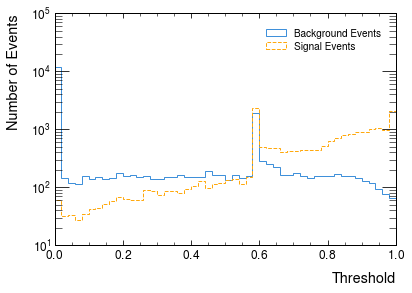

In [189]:
plt.hist(decisions_nn_full[y_test == 0], histtype="step", bins=50, label="Background Events")  # plot background
plt.hist(decisions_nn_full[y_test == 1], histtype="step",bins=50,linestyle="dashed",label="Signal Events",)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend

In [190]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, decisions_rf)
fpr_nn_full, tpr_nn_full, thresholds_nn_full = roc_curve(y_test, decisions_nn_full)

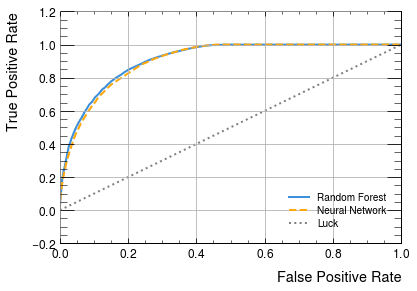

In [191]:
plt.plot(fpr_rf, tpr_rf, label="Random Forest")  # plot random forest ROC
plt.plot(fpr_nn_full, tpr_nn_full, linestyle="dashed", label="Neural Network")  # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
plt.xlabel("False Positive Rate")  # x-axis label
plt.ylabel("True Positive Rate")  # y-axis label
plt.grid()  # add a grid to the plot
plt.legend()

In [192]:
def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS

In [193]:
b_reg = 0.001
ams_rf = AMS(tpr_rf,fpr_rf,b_reg)
ams_nn_full = AMS(tpr_nn_full,fpr_nn_full,b_reg)

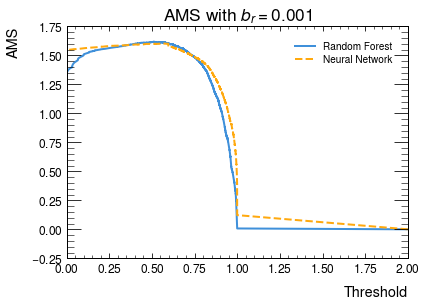

In [194]:
plt.plot(thresholds_rf, ams_rf, label="Random Forest")  # plot random forest AMS
plt.plot(thresholds_nn_full, ams_nn_full, linestyle="dashed", label="Neural Network")  # plot neural network AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()

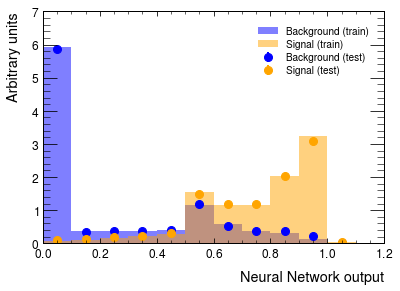

In [198]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
compare_train_test(NN_clf_full, X_train_scaled, y_train, X_test_scaled, y_test, "Neural Network output")

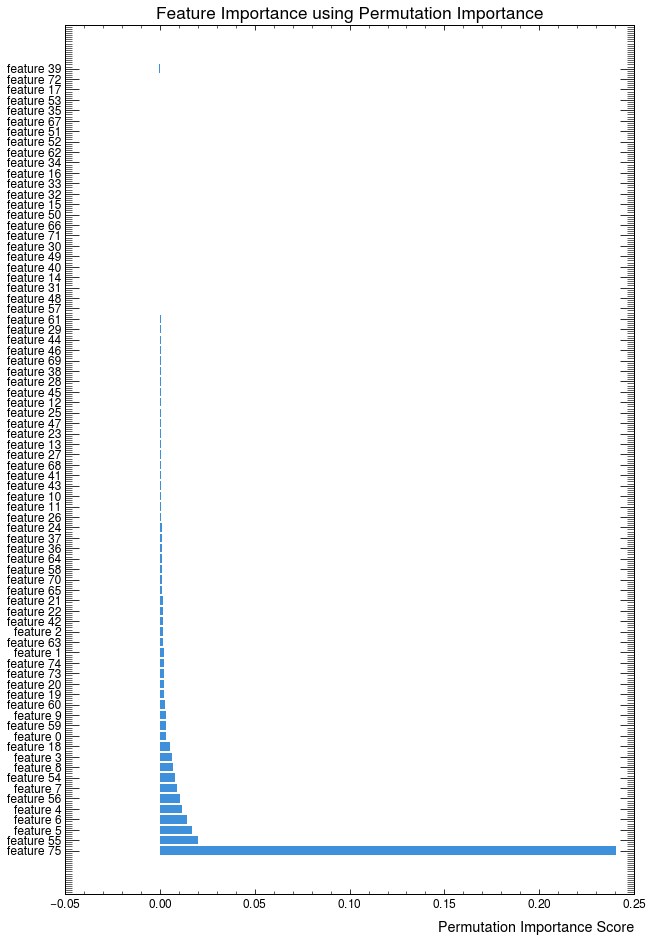

In [197]:
from sklearn.inspection import permutation_importance
# Calculate permutation importance
results = permutation_importance(NN_clf_full, X_test_tensor, y_test_tensor, n_repeats=30, random_state=42)

# Get the importance scores
importance_scores = results.importances_mean

# Rank the features based on importance
feature_importance = sorted(zip(importance_scores), reverse=True)

sorted_indices = np.argsort(importance_scores)[::-1]
feature_names = [f"feature {i}" for i in range(len(X[0]))]

# Sort the importance scores and feature names
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_importance_scores, align='center')
plt.xlabel('Permutation Importance Score')
plt.title('Feature Importance using Permutation Importance')
plt.show()